In [1]:
import torch
print("----------------")
!python --version
print("----------------")
!nvcc --version
print("----------------")
print("torch.cuda.is_available: ",torch.cuda.is_available())
print("----------------")
print(torch.cuda.get_device_name(0))
print("----------------")
print(torch.__version__)
!nvidia-smi

----------------
Python 3.9.19
----------------
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_19:00:59_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0
----------------
torch.cuda.is_available:  True
----------------
NVIDIA GeForce RTX 3090
----------------
2.2.1
Fri Nov  8 21:19:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.17                 Driver Version: 546.17       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def add_colorbar(ax, im, bbox_transform, #ax.transAxes
                 width="5%", 
                 height="100%",
                 loc='lower left',
                 bbox_to_anchor=(1.01, 0., 1, 1),
                 borderpad=0,
                 ctitle=''):
    axins = inset_axes(ax,
                       width=width, 
                       height=height,
                       loc=loc,
                       bbox_to_anchor=bbox_to_anchor,
                       bbox_transform=bbox_transform,
                       borderpad=borderpad)
    cbar = plt.colorbar(im, cax=axins)
    axins.set(title=ctitle)
    return cbar
    
def imagesc(fig,
            images,
            vmin=1.5,
            vmax=4.5,
            extent=[0, 1.01, 1.01, 0],
            aspect=1,
            nRows_nCols=(1, 1),
            cmap='RdBu_r',
            ylabel="Depth (km)",
            xlabel="Position (km)",
            clabel="km/s",
            fontsize=2,
            xticks=np.arange(0., 1.01, 0.4),
            yticks=np.arange(0., 1.01, 0.4),
            cbar_width="5%",
            cbar_height="100%",
            cbar_loc='lower left',
            cbar_mode="corner",
            bbox_to_anchor=(1.05, 0., 1, 1.),
            ):
    (nrow, ncol) = nRows_nCols
    if not isinstance(vmin, (list, tuple, np.ndarray)) or not isinstance(vmax, (list, tuple, np.ndarray)):
        vmin = [vmin] * nrow
        vmax = [vmax] * nrow
    
    gs = fig.add_gridspec(nrow, ncol)
    for irow in range(nrow):
        for icol in range(ncol):
            ax = fig.add_subplot(gs[irow, icol])
            #print("irow and icol", irow, icol)
            #print(images[irow, icol].shape)
            im = ax.imshow(images[irow, icol], 
                           vmin=vmin[irow], vmax=vmax[irow], 
                           extent=extent,
                           aspect=aspect,
                           cmap=cmap)
            if icol == 0:
                ax.set_ylabel(ylabel, fontsize=fontsize)
                if yticks is not None:
                    ax.set_yticks(yticks)
            else:
                ax.set_yticks([])
            if irow == nrow - 1:
                ax.set_xlabel(xlabel, fontsize=fontsize)
                if xticks is not None:
                    ax.set_xticks(xticks)
            else:
                ax.set_xticks([])
            ax.tick_params(axis='both', labelsize=fontsize, which='major', pad=0.1)

            cbar_plot = False
            if cbar_mode == 'corner' and (irow == nrow-1 and icol == ncol-1):
                cbar_plot = True
            elif cbar_mode =='row' and (icol == ncol-1):
                cbar_plot = True
            elif cbar_mode == 'each':
                cbar_plot = True
            if cbar_plot is True:
                axins = inset_axes(ax,
                               width=cbar_width, 
                               height=cbar_height,
                               loc=cbar_loc,
                               bbox_to_anchor=bbox_to_anchor,
                               bbox_transform=ax.transAxes,
                               borderpad=0,
                               )
                axins.tick_params(axis='both', labelsize=fontsize, which='major', pad=0.1)
                cbar = plt.colorbar(im, cax=axins)
                cbar.ax.set_ylabel(clabel, fontsize=fontsize)
    return

In [4]:
npzfile = np.load(r'./SEGoverthrust.npz')
print(npzfile.files)
vmodel = npzfile['vmodel']
dx, dy, dz = npzfile['dx'], npzfile['dy'], npzfile['dz']
x, y, z = npzfile['x'], npzfile['y'], npzfile['z']

print("The original model shape: ", vmodel.shape)

[ny, nz, nx] = vmodel.shape
"""Resize the model"""
nnz = np.arange(0,nz,2).tolist()
nnx = np.arange(0,nx,4).tolist()

vmodels = vmodel[:, nnz,:]; vmodels=vmodels[:, :,nnx]; vmodels=vmodels[:,:,:]
# Set top layer to be consistent
vmodels[:,:2,:]=np.amin(vmodels)
print("The resized model shape: ", vmodels.shape)

vp_true =vmodels[-775].squeeze()
vp_true = vp_true[6:66,:]
vp_true = vp_true[:,:]-1000 
vs_true =vp_true *0.7

vp_true = torch.as_tensor(vp_true)
vs_true = torch.as_tensor(vs_true)

[nz, nx] = [vp_true.shape[0],vp_true.shape[1]]
rho_true = torch.ones([nz,nx])

for i in range(nz):
    for j in range(nx):
        rho_true[i,j] = 0.25*math.pow(vp_true[i,j],0.23)*1000

vp_true = torch.as_tensor(vp_true, dtype=torch.float32)
vs_true = torch.as_tensor(vs_true, dtype=torch.float32)
rho_true = torch.as_tensor(rho_true, dtype=torch.float32)



print("Geological Model Shape: {}".format(vp_true.shape))
print("Min & Max: Vp[{:.4f}, {:.4f}], Vs[{:.4f}, {:.4f}], Rho[{:.4f}, {:.4f}]"
      .format(vp_true.min(), vp_true.max(), vs_true.min(), vs_true.max(), rho_true.min(), rho_true.max()))
print("Mean & Std: Vp[{:.4f}, {:.4f}], Vs[{:.4f}, {:.4f}], Rho[{:.4f}, {:.4f}]"
      .format(vp_true.mean(), vp_true.std(), vs_true.mean(), vs_true.std(), rho_true.mean(), rho_true.std()))

vp_tensor = torch.as_tensor(vp_true).type(dtype=torch.float32).to(device)
vs_tensor = torch.as_tensor(vs_true).type(dtype=torch.float32).to(device)
rho_tensor = torch.as_tensor(rho_true).type(dtype=torch.float32).to(device)
print("vp_mean, vp_std, vs_mean, vs_std, rho_mean, rho_std after as tensor", vp_tensor.mean(), vp_tensor.std(), vs_tensor.mean(), vs_tensor.std(), rho_tensor.mean(), rho_tensor.std())

print("this is the shape of the vp, vs and tho", vp_tensor.shape, vs_tensor.shape, rho_tensor.shape)
print(vp_tensor)

['vmodel', 'dx', 'dy', 'dz', 'x', 'y', 'z']
The original model shape:  (801, 187, 801)
The resized model shape:  (801, 94, 201)
Geological Model Shape: torch.Size([60, 201])
Min & Max: Vp[1605.0000, 4500.0000], Vs[1123.5000, 3150.0000], Rho[1365.2094, 1730.5291]
Mean & Std: Vp[2997.9243, 796.2834], Vs[2098.5474, 557.3984], Rho[1566.3640, 96.2326]
vp_mean, vp_std, vs_mean, vs_std, rho_mean, rho_std after as tensor tensor(2997.9243, device='cuda:0') tensor(796.2834, device='cuda:0') tensor(2098.5474, device='cuda:0') tensor(557.3984, device='cuda:0') tensor(1566.3640, device='cuda:0') tensor(96.2326, device='cuda:0')
this is the shape of the vp, vs and tho torch.Size([60, 201]) torch.Size([60, 201]) torch.Size([60, 201])
tensor([[2250., 2250., 2250.,  ..., 2216., 2216., 2216.],
        [2500., 2500., 2500.,  ..., 2311., 2311., 2323.],
        [2500., 2500., 2500.,  ..., 2316., 2461., 2500.],
        ...,
        [4500., 4500., 4500.,  ..., 4500., 4500., 4500.],
        [4345., 4345., 434

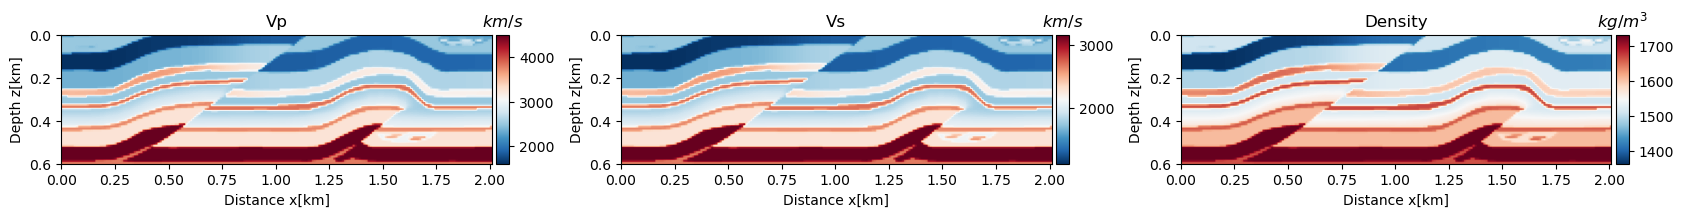

In [5]:
dx = 10
dz = 10

fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 3)
ax = fig.add_subplot(gs[0, 0])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="Vp")
im = ax.imshow(vp_tensor.cpu().squeeze(), extent=[0, nx*dx/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')


ax = fig.add_subplot(gs[0, 1])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="Vs")
im = ax.imshow(vs_tensor.cpu().squeeze(), extent=[0, nx*dx/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')

ax = fig.add_subplot(gs[0, 2])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="Density")
im = ax.imshow(rho_tensor.cpu().squeeze(), extent=[0, nx*dx/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$kg/m^3$')

plt.subplots_adjust(left=0.125,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=-0.8)

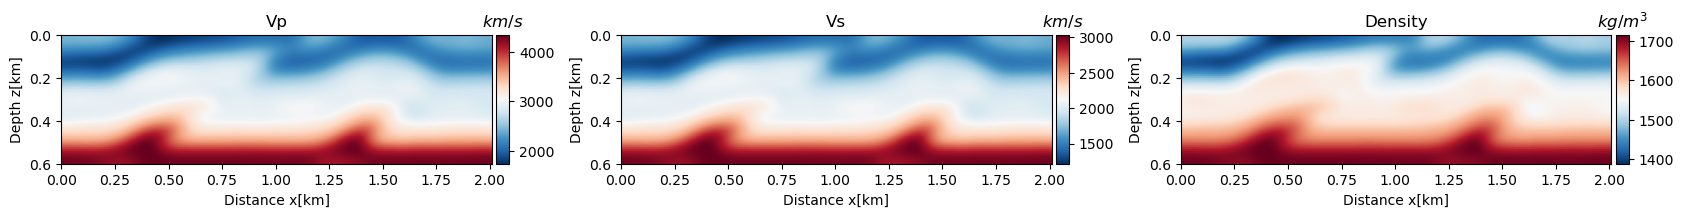

In [6]:
from scipy.ndimage import gaussian_filter
vp_initial = torch.as_tensor(gaussian_filter(vp_tensor.cpu().clone().detach().numpy(), sigma=4)).to(device)
vs_initial = torch.as_tensor(gaussian_filter(vs_tensor.cpu().clone().detach().numpy(), sigma=4)).to(device)
rho_initial = torch.as_tensor(gaussian_filter(rho_tensor.cpu().clone().detach().numpy(), sigma=4)).to(device)

fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(1, 3)
ax = fig.add_subplot(gs[0, 0])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="Vp")
im = ax.imshow(vp_initial.cpu().squeeze(), extent=[0, nx*dx/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')


ax = fig.add_subplot(gs[0, 1])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="Vs")
im = ax.imshow(vs_initial.cpu().squeeze(), extent=[0, nx*dx/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$km/s$')

ax = fig.add_subplot(gs[0, 2])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="Density")
im = ax.imshow(rho_initial.cpu().squeeze(), extent=[0, nx*dx/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r')
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$kg/m^3$')


plt.subplots_adjust(left=0.125,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=-0.8)

In [7]:
from rnn_fd_elastic2 import rnn2D
from generator import wGenerator
sample_interval = 30
freeSurface = False                                                      # free surface option for forward modeling
npad = 10                                                               # velocity padding in grid points
freq = 15.0                                                             # dominant frequency of wavelet in Hz
dt = 0.0008                                                             # time samling interval, fixed for all shots gathers
nt = 1200                                                                # number of samples in time
nv = 1  

xs = np.arange(2,nx,30,dtype=np.int32) # source x-coordinate
zs = np.ones(xs.shape, dtype=np.int32) # source z-coordinate

xr = np.arange(0,nx, 1, dtype=np.int32) # receiver x-coordinate
zr = np.ones(xr.shape, dtype=np.int32) # receiver z-coordinate

t = dt * torch.arange(0, nt, dtype=torch.float32)                       # create time vector
wavelet = wGenerator(t, freq).ricker().to(device)*10000000              # generate wavelet

vp_tensor = torch.reshape(vp_tensor,(1,nz,nx)).type(dtype=torch.float32).to(device)
vs_tensor = torch.reshape(vs_tensor,(1,nz,nx)).type(dtype=torch.float32).to(device)
rho_tensor = torch.reshape(rho_tensor,(1,nz,nx)).type(dtype=torch.float32).to(device)

forward_rnn = rnn2D(nz, nx, zs, xs, zr, xr, dz, dt, 
                    npad=npad, order=2, vmax=vp_tensor.max(), 
                    freeSurface=True, 
                    dtype=torch.float32, 
                    device=device).to(device)

# forward modeling
vx_save, vz_save, \
txx_save, tzz_save, txz_save, \
segment_ytPred_x,segment_ytPred_z,avg_regularizer,\
vp_tensor_out,vs_tensor_out,rho_tensor_out = \
forward_rnn(vp_tensor=vp_tensor.to(device),\
            vs_tensor=vs_tensor.to(device),\
            rho_tensor=rho_tensor.to(device),\
            segment_wavelet=wavelet)




torch.Size([7, 1200, 201])


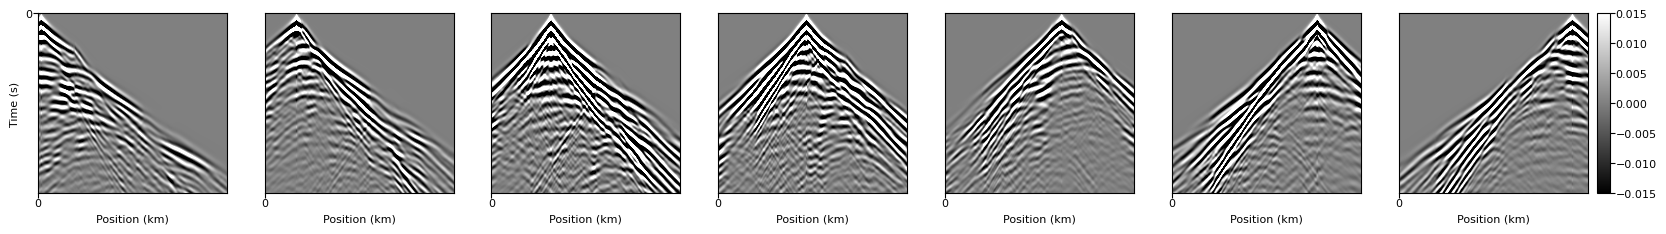

In [8]:
print(segment_ytPred_z.shape)
fig=plt.figure(figsize=(20, 5))
imagesc(fig,
        segment_ytPred_z.cpu().numpy().reshape(-1, int(len(xs)), len(t), len(xr)),
        vmin=-segment_ytPred_z.max()/100,
        vmax=segment_ytPred_z.max()/100,
        extent=[0, nx*dz/1000, t.numpy().max(), 0],
        aspect=2, #5
        nRows_nCols=(1,len(xs)),
        cmap='gray',
        ylabel="Time (s)",
        xlabel="Position (km)",
        clabel="",
        xticks=np.arange(0., int(nx*dz/1000), 2),
        yticks=np.arange(0., t.numpy().max(), 1.),
        fontsize=8,
        cbar_width="7%",
        cbar_height="100%",
        cbar_loc='lower left')

torch.Size([7, 1200, 201])


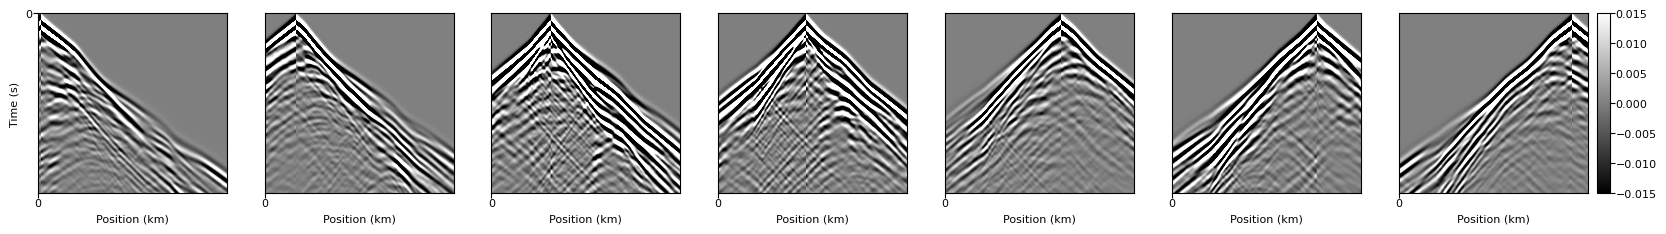

In [9]:
print(segment_ytPred_z.shape)
fig=plt.figure(figsize=(20, 5))
imagesc(fig,
        segment_ytPred_x.cpu().numpy().reshape(-1, int(len(xs)), len(t), len(xr)),
        vmin=-segment_ytPred_z.max()/100,
        vmax=segment_ytPred_z.max()/100,
        extent=[0, nx*dz/1000, t.numpy().max(), 0],
        aspect=2, #5
        nRows_nCols=(1,len(xs)),
        cmap='gray',
        ylabel="Time (s)",
        xlabel="Position (km)",
        clabel="",
        xticks=np.arange(0., int(nx*dz/1000), 2),
        yticks=np.arange(0., t.numpy().max(), 1.),
        fontsize=8,
        cbar_width="7%",
        cbar_height="100%",
        cbar_loc='lower left')

In [10]:
shots= torch.cat((segment_ytPred_x.reshape(1, len(xs),len(t), len(xr)),\
                  segment_ytPred_z.reshape(1, len(xs),len(t), len(xr))),dim=0)
print(shots.shape)

torch.Size([2, 7, 1200, 201])


In [11]:
vp_tensor_initial = torch.as_tensor(vp_initial).to(device).requires_grad_(True)
vs_tensor_initial = torch.as_tensor(vs_initial).to(device).requires_grad_(True)
rho_tensor_initial = torch.as_tensor(rho_initial).to(device).requires_grad_(True)

In [12]:
from FWI2D import FWI2D

model = FWI2D( segment_size=len(t),
                ns = len(xs), 
                nz=nz,
                nx=nx,
                zs=zs,
                xs=xs,
                zr=zr, 
                xr=xr,
                dz=dz,
                dt=dt,
                nt=nt,
                npad=npad, 
                order=2, 
                vmax=4700,
                vpadding=None,
                obj_option = 1,
                freeSurface=True,
                dtype=torch.float32,
                device=device)

train_loss_history,velocity_output1, velocity_output2, velocity_output3,segment_ytPred_x,segment_ytPred_z = model.train(vmodel1=vp_tensor_initial,
                                                                                                                        vmodel2=vs_tensor_initial,
                                                                                                                        vmodel3=rho_tensor_initial,
                                                                                                                        MaxIter=200,
                                                                                                                        wavelet=wavelet,
                                                                                                                        shots=shots,
                                                                                                                        option=0,
                                                                                                                        log_interval=1)

Using the L1 Norm objective function
Epoch:     0, Loss: 3.2250e+04
Epoch:     1, Loss: 2.9738e+04
Epoch:     2, Loss: 2.7482e+04
Epoch:     3, Loss: 2.5660e+04
Epoch:     4, Loss: 2.4346e+04
Epoch:     5, Loss: 2.3313e+04
Epoch:     6, Loss: 2.2417e+04
Epoch:     7, Loss: 2.1585e+04
Epoch:     8, Loss: 2.0810e+04
Epoch:     9, Loss: 2.0118e+04
Epoch:    10, Loss: 1.9498e+04
Epoch:    11, Loss: 1.8941e+04
Epoch:    12, Loss: 1.8427e+04
Epoch:    13, Loss: 1.7952e+04
Epoch:    14, Loss: 1.7474e+04
Epoch:    15, Loss: 1.6983e+04
Epoch:    16, Loss: 1.6515e+04
Epoch:    17, Loss: 1.6071e+04
Epoch:    18, Loss: 1.5588e+04
Epoch:    19, Loss: 1.5063e+04
Epoch:    20, Loss: 1.4569e+04
Epoch:    21, Loss: 1.4135e+04
Epoch:    22, Loss: 1.3724e+04
Epoch:    23, Loss: 1.3316e+04
Epoch:    24, Loss: 1.2928e+04
Epoch:    25, Loss: 1.2556e+04
Epoch:    26, Loss: 1.2183e+04
Epoch:    27, Loss: 1.1797e+04
Epoch:    28, Loss: 1.1410e+04
Epoch:    29, Loss: 1.1056e+04
Epoch:    30, Loss: 1.0710e+04
Ep

In [13]:
velocity_output1.shape

torch.Size([60, 201])

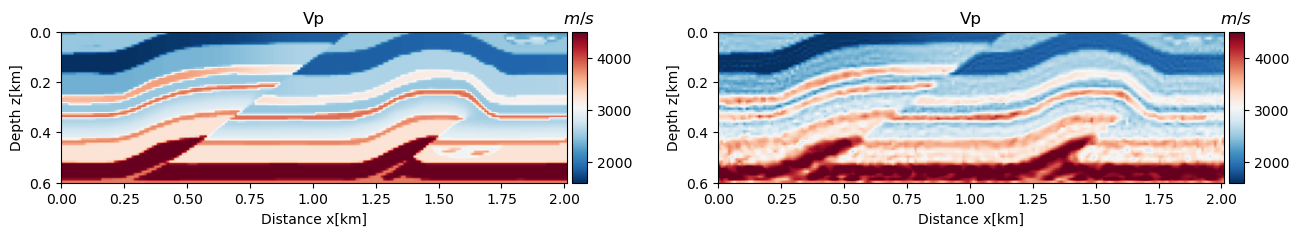

In [14]:
fig = plt.figure(figsize=(15, 7))
gs = fig.add_gridspec(1, 2)
ax = fig.add_subplot(gs[0, 0])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="Vp")
im = ax.imshow(vp_tensor.cpu().squeeze(), extent=[0, nx*dx/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r', vmin=vp_tensor.min(), vmax=vp_tensor.max(), )
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$m/s$')

ax = fig.add_subplot(gs[0, 1])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="Vp")
im = ax.imshow(velocity_output1.cpu().detach().numpy().squeeze(), extent=[0, nx*dx/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r', vmin=vp_tensor.min(), vmax=vp_tensor.max(), )
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$m/s$')


plt.subplots_adjust(left=0.125,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=-0.8)

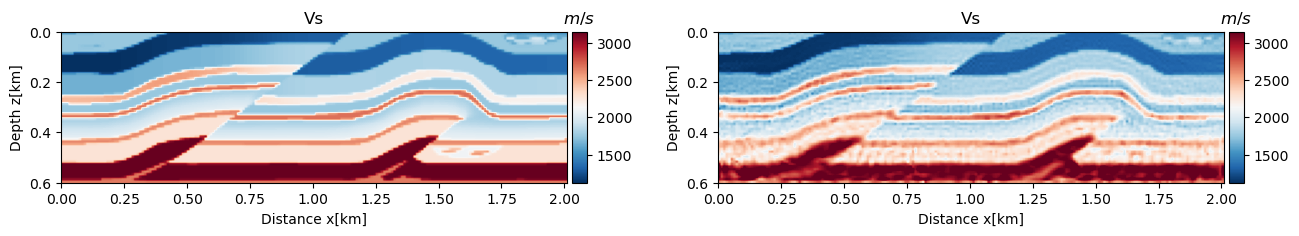

In [15]:
fig = plt.figure(figsize=(15, 7))
gs = fig.add_gridspec(1, 2)
ax = fig.add_subplot(gs[0, 0])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="Vs")
im = ax.imshow(vs_tensor.cpu().squeeze(), extent=[0, nx*dx/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r', vmin=vs_tensor.min(), vmax=vs_tensor.max(), )
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$m/s$')

ax = fig.add_subplot(gs[0, 1])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title="Vs")
im = ax.imshow(velocity_output2.cpu().detach().numpy().squeeze(), extent=[0, nx*dx/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r', vmin=vs_tensor.min(), vmax=vs_tensor.max(), )
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$m/s$')


plt.subplots_adjust(left=0.125,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=-0.8)

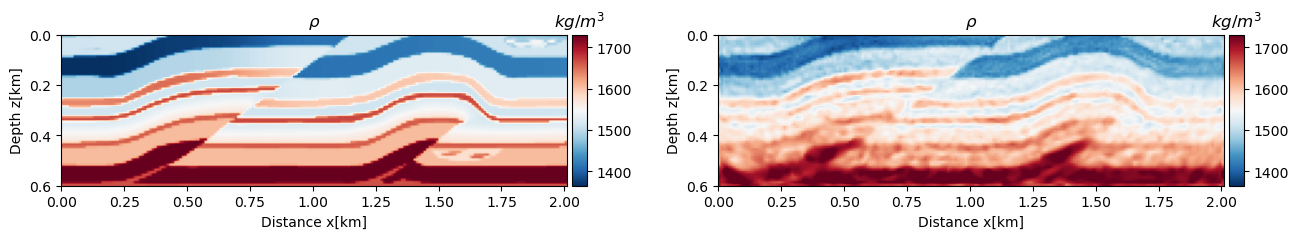

In [20]:
fig = plt.figure(figsize=(15, 7))
gs = fig.add_gridspec(1, 2)
ax = fig.add_subplot(gs[0, 0])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title=r"$\rho$")
im = ax.imshow(rho_tensor.cpu().squeeze(), extent=[0, nx*dx/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r', vmin=rho_tensor.min(), vmax=rho_tensor.max(), )
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$kg/m^{3}$')

ax = fig.add_subplot(gs[0, 1])
ax.set(ylabel="Depth z[km]", xlabel="Distance x[km]", title=r"$\rho$")
im = ax.imshow(velocity_output3.cpu().detach().numpy().squeeze(), extent=[0, nx*dx/1000, nz*dz/1000, 0], aspect=1, cmap='RdBu_r',vmin=rho_tensor.min(), vmax=rho_tensor.max(), )
cbar = add_colorbar(ax, im, ax.transAxes, width="3%", ctitle='$kg/m^{3}$')


plt.subplots_adjust(left=0.125,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.3,
                    hspace=-0.8)

torch.Size([7, 1200, 201])


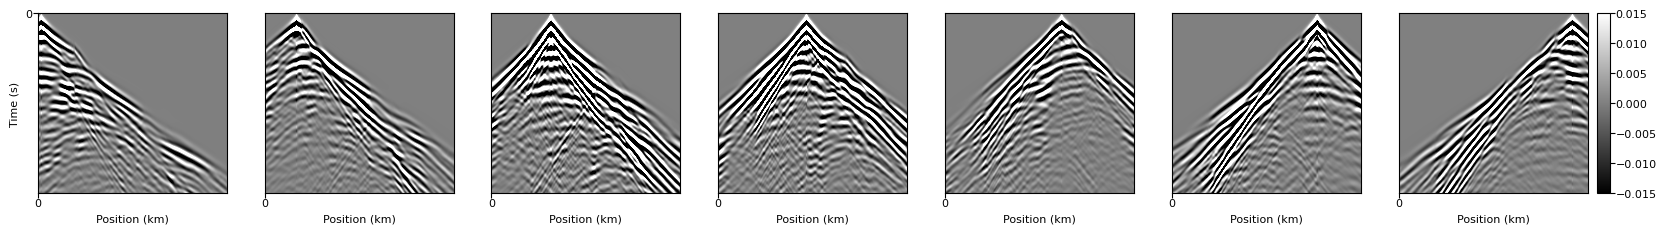

In [17]:
print(segment_ytPred_z.shape)
fig=plt.figure(figsize=(20, 5))
imagesc(fig,
        segment_ytPred_z.cpu().detach().numpy().reshape(-1, int(len(xs)), len(t), len(xr)),
        vmin=-segment_ytPred_z.max()/100,
        vmax=segment_ytPred_z.max()/100,
        extent=[0, nx*dz/1000, t.numpy().max(), 0],
        aspect=2, #5
        nRows_nCols=(1,len(xs)),
        cmap='gray',
        ylabel="Time (s)",
        xlabel="Position (km)",
        clabel="",
        xticks=np.arange(0., int(nx*dz/1000), 2),
        yticks=np.arange(0., t.numpy().max(), 1.),
        fontsize=8,
        cbar_width="7%",
        cbar_height="100%",
        cbar_loc='lower left')

torch.Size([7, 1200, 201])


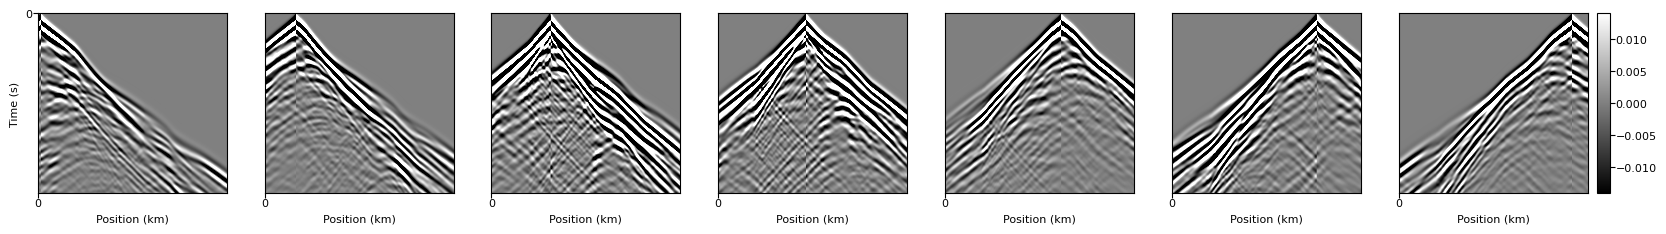

In [18]:
print(segment_ytPred_x.shape)
fig=plt.figure(figsize=(20, 5))
imagesc(fig,
        segment_ytPred_x.cpu().detach().numpy().reshape(-1, int(len(xs)), len(t), len(xr)),
        vmin=-segment_ytPred_x.max()/100,
        vmax=segment_ytPred_x.max()/100,
        extent=[0, nx*dz/1000, t.numpy().max(), 0],
        aspect=2, #5
        nRows_nCols=(1,len(xs)),
        cmap='gray',
        ylabel="Time (s)",
        xlabel="Position (km)",
        clabel="",
        xticks=np.arange(0., int(nx*dz/1000), 2),
        yticks=np.arange(0., t.numpy().max(), 1.),
        fontsize=8,
        cbar_width="7%",
        cbar_height="100%",
        cbar_loc='lower left')